<a href="https://colab.research.google.com/github/mosahle7/ML/blob/main/Fashon_MNIST_using_MobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Dataset**

In [82]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import random

In [83]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [84]:
def load_data(batch_size, data_dir = "data"):
  transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5,),(0.5,))]
  )

  full_trainset = datasets.FashionMNIST(
      data_dir,
      download=True,
      train=True,
      transform=transform
  )

  train_len = int(0.9*len(full_trainset))
  val_len = len(full_trainset) - train_len
  train, val = random_split(full_trainset, [train_len, val_len])

  trainloader = torch.utils.data.DataLoader(
      train,
      batch_size = batch_size,
      shuffle = True
  )

  valloader = torch.utils.data.DataLoader(
      val,
      batch_size = batch_size,
      shuffle = True
  )

  test = datasets.FashionMNIST(
      data_dir,
      download = True,
      train = False,
      transform = transform
  )

  testloader = torch.utils.data.DataLoader(
      test,
      batch_size = batch_size,
      shuffle=True
  )

  return trainloader, valloader, testloader

trainloader, valloader, testloader = load_data(64)

In [86]:
def get_class_names():
  return [
      "T-shirt/top",
      "Trouser",
      "Pullover",
      "Dress",
      "Coat",
      "Sandal",
      "Shirt",
      "Sneaker",
      "Bag",
      "Ankle boot",
  ]

In [87]:
def get_class_name(class_idx):
  return get_class_names()[class_idx]

In [88]:
def get_class_idx(class_name):
  return get_class_names.index(class_name)

In [89]:
import matplotlib.pyplot as plt
import numpy as np

In [90]:
def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

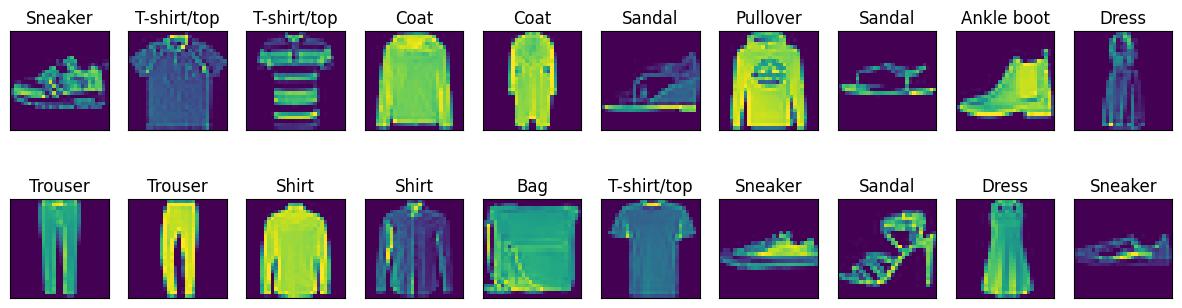

In [91]:
images, labels = next(iter(trainloader))

fig = plt.figure(figsize=(15,4))
plot_size = 20

for ind in np.arange(plot_size):
  ax = fig.add_subplot(2, plot_size // 2, ind + 1, xticks=[], yticks=[])
  imshow(images[ind])
  ax.set_title(get_class_name(int(labels[ind])))

**Model using MobileNetV3**

In [92]:
import torchvision.models as models

In [93]:
mobilenet_v3_model = models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [94]:
import torch.nn.functional as F
import torchvision.models as models
from torch import nn

In [95]:
class MobileNetV3(nn.Module):
  def __init__(self):
    super(MobileNetV3, self).__init__()
    self.model = mobilenet_v3_model
    self.model.classifier[3] = nn.Linear(in_features=1024, out_features=10, bias=True)
    self.freeze()

  def forward(self,x):
    x = x.repeat(1,3,1,1)
    if x.shape[2:] != (224,224):
      x = F.interpolate(x, size=(224,224),mode='bilinear',align_corners=False)
    return self.model(x)

  def freeze(self):
    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.model.classifier[3].parameters():
      param.requires_grad = True

  def unfreeze(self):
    for param in self.model.parameters():
      param.requires_grad = True


In [96]:
model = MobileNetV3()
model

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

**Train model on MNIST Dataset**

In [97]:
import torch.nn as nn
import torch.optim as optim

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [99]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [103]:
model = model.to(device)
best_val_loss = float('inf')
patience = 3
best_model_state = None
epochs = 20

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for batch_num, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)

    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if batch_num%100 == 0:
      print(
          "Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(
              epoch+1, epochs, batch_num+1, len(trainloader), loss.item()
          )
      )

  model.eval()
  val_loss = 0.0
  crct = 0
  total = 0

  with torch.no_grad():
    for images, labels in valloader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = loss_fn(outputs, labels)
          val_loss += loss.item()

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          crct += (predicted == labels).sum().item()

  avg_train_loss = running_loss/len(trainloader)
  avg_val_loss = val_loss/len(valloader)
  val_accuracy = 100* crct/total

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    counter = 0
    best_model_state = model.state_dict()
  else:
    counter+=1
    if counter>=patience:
      print(f"Early stopping at epoch {epoch+1}")
      break

  print(f"Epoch [{epoch + 1}/{epochs}] Summary:")
  print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model weights restored (from epoch with lowest val loss).")


Epoch [1/20], Batch [1/844], Loss: 0.3958
Epoch [1/20], Batch [101/844], Loss: 0.3134
Epoch [1/20], Batch [201/844], Loss: 0.4436
Epoch [1/20], Batch [301/844], Loss: 0.4202
Epoch [1/20], Batch [401/844], Loss: 0.2443
Epoch [1/20], Batch [501/844], Loss: 0.3642
Epoch [1/20], Batch [601/844], Loss: 0.2680
Epoch [1/20], Batch [701/844], Loss: 0.3500
Epoch [1/20], Batch [801/844], Loss: 0.3761
Epoch [1/20] Summary:
Train Loss: 0.3552 | Val Loss: 0.3357 | Val Accuracy: 88.08%

Epoch [2/20], Batch [1/844], Loss: 0.2148
Epoch [2/20], Batch [101/844], Loss: 0.4493
Epoch [2/20], Batch [201/844], Loss: 0.3107
Epoch [2/20], Batch [301/844], Loss: 0.3871
Epoch [2/20], Batch [401/844], Loss: 0.5230
Epoch [2/20], Batch [501/844], Loss: 0.3349
Epoch [2/20], Batch [601/844], Loss: 0.3510
Epoch [2/20], Batch [701/844], Loss: 0.3131
Epoch [2/20], Batch [801/844], Loss: 0.4736
Epoch [2/20] Summary:
Train Loss: 0.3555 | Val Loss: 0.3352 | Val Accuracy: 87.92%

Epoch [3/20], Batch [1/844], Loss: 0.4128
Ep

**Evaluate Model on Test Set**

In [105]:
crct = 0
total = 0
loss = 0

for images, labels in testloader:
  images = images.to(device)
  labels = labels.to(device)

  outputs = model(images)
  loss += loss_fn(outputs, labels).item()

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  crct += (predicted == labels).sum().item()


print("Test Accuracy of model: {} %".format(100*crct/total))
print("Test Loss of model: {}".format(loss/len(testloader)))




Test Accuracy of model: 87.48 %
Test Loss of model: 0.35226847070037937


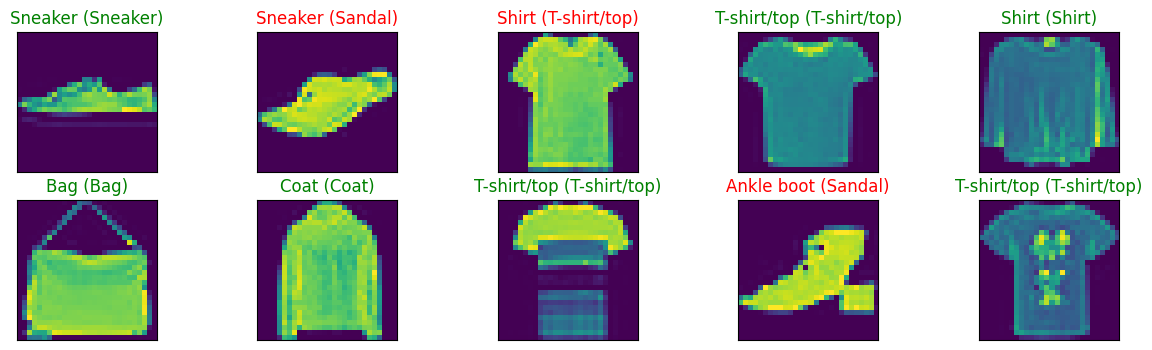

In [74]:
images, labels = next(iter(testloader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

fig = plt.figure(figsize=(15,4))

for idx in np.arange(min(10, len(images))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images.cpu()[idx]))
    ax.set_title(
        "{} ({})".format(get_class_name(predicted[idx]), get_class_name(labels[idx])),
        color=("green" if predicted[idx] == labels[idx] else "red"),
    )
